# Pytorch: Defining New Autograd Functions
https://pytorch.org/tutorials/beginner/examples_autograd/polynomial_custom_function.html  

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib



PyTorch: Defining New autograd Functions
----------------------------------------

A third order polynomial, trained to predict $y=\sin(x)$ from $-\pi$
to $pi$ by minimizing squared Euclidean distance. Instead of writing the
polynomial as $y=a+bx+cx^2+dx^3$, we write the polynomial as
$y=a+b P_3(c+dx)$ where $P_3(x)=\frac{1}{2}\left(5x^3-3x\right)$ is
the [`Legendre polynomial`](https://en.wikipedia.org/wiki/Legendre_polynomials) of degree three. 

This implementation computes the forward pass using operations on PyTorch
Tensors, and uses PyTorch autograd to compute gradients.

In this implementation we implement our own custom autograd function to perform
$P_3'(x)$. By mathematics, $P_3'(x)=\frac{3}{2}\left(5x^2-1\right)$



In [2]:
import math

import torch


dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0")  # Uncomment this to run on GPU

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, device = device, dtype = dtype)
y = torch.sin(x)

### Custom Autograd Functions
An autograd Function needs to provide 'forward' and 'backward' functions to calculate output and gradient.
一個自訂的 function 如果要能提供 autograd 的功能，則必須要提供 'forward' and 'backward' functions。

In [3]:
# custom autograd Functions

class LegendrePolynomial3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """


    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return (5 * input ** 3 - 3 * input) / 2


    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return 1.5 * (5 * input ** 2 - 1) * grad_output


P3 = LegendrePolynomial3.apply

In [4]:
# Create random Tensors for weights. For this example, we need
# 4 weights: y = a + b * P3(c + d * x), these weights need to be initialized
# not too far from the correct result to ensure convergence.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device = device, dtype = dtype, requires_grad = True)
b = torch.full((), -1.0, device = device, dtype = dtype, requires_grad = True)
c = torch.full((), 0.0, device = device, dtype = dtype, requires_grad = True)
d = torch.full((), 0.3, device = device, dtype = dtype, requires_grad = True)

learning_rate = 5e-6

for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.

    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()

    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} * x)')

99 209.95834350585938
199 144.66018676757812
299 100.70249938964844
399 71.03520202636719
499 50.978515625
599 37.40313720703125
699 28.20686912536621
799 21.973186492919922
899 17.745729446411133
999 14.877889633178711
1099 12.931766510009766
1199 11.610918998718262
1299 10.714248657226562
1399 10.105474472045898
1499 9.692106246948242
1599 9.411375045776367
1699 9.220745086669922
1799 9.091285705566406
1899 9.003361701965332
1999 8.943639755249023
Result: y = -1.6666938662535102e-10 + -2.208526849746704 * P3(1.4752160604203368e-10 + 0.2554861009120941 * x)


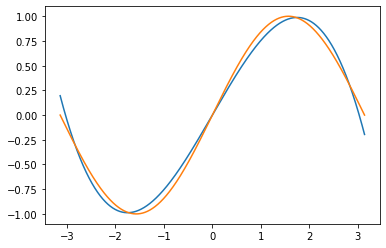

In [5]:
y = a + b * P3(c + d * x)

plt.plot(x.cpu(), y.cpu().detach()); 
plt.plot(x.cpu(), np.sin(x.cpu()));